# ECBM4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know the basic fully connected neural network.

In [9]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
try:
    import _pickle as pickle
except ImportError:
    import pickle as pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [10]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./ecbm4040/layer_funcs.py**.

In [25]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

# Affine function -- H = W*X + b
# print('x shape {}'.format(x.shape))
# print('w shape {}'.format(w.shape))
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./ecbm4040/layer_funcs.py**.

In [51]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

# Activation layers -- Here we introduce ReLU/Leaky ReLU activation functions
# since they are the most commonly used in computer vision problems.
# However, you can also try to implement other activation functions like sigmoid, tanh etc. 
x = X_dev
dout = np.ones(x.shape)
# ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./ecbm4040/layer_funcs.py**

In [52]:
from ecbm4040.layer_funcs import softmax_loss

# generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./ecbm4040/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./ecbm4040/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform >> Softmax and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./ecbm4040/layer_utils.py**

In [68]:
x.shape

(100, 3072)

In [64]:
# First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

# Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./ecbm4040/layer_utils.py**

In [66]:
from ecbm4040.layer_utils import AffineLayer

# Affine + ReLU
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**

In [83]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

# Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-5)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-5*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

how do I back prop
Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [12]:
from ecbm4040.train_funcs import train, test

#### Start training
<span style="color:red"><strong>TODO</strong></span>: Use previous layers to create a two layer neural network:

**input->(affine->activation)->(affine->softmax)->output**

The recommended activation function is ReLU. You can also make a comparison with other activation function to see any difference.

In [60]:
np.exp(-100)

3.7200759760208361e-44

In [61]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=0.25, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
zer0 False
-1.21627675641
zer0 False
-696.110831704
zer0 True
-6591.75104876
zer0 True
-14342.0580787
zer0 True
-406473.003864
zer0 True
-5345817.31264
zer0 True
-63251501.112
zer0 True
-548322940.643
zer0 True
-11045835766.1


/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:192: RuntimeWarning: divide by zero encountered in log
  dx = sm


zer0 True
-283322330946.0
5000/49000 loss: inf
zer0 True
-2.61034849872e+12
zer0 True
-1.96446169983e+13
zer0 True
-5.4303629249e+14
zer0 True
-4.70198699986e+15
zer0 True
-2.15727855206e+16
zer0 True
-1.60125022408e+17
zer0 True
-8.2574490845e+17
zer0 True
-8.87852640467e+18
zer0 True
-8.64830943714e+19
zer0 True
-2.49860420682e+20
10000/49000 loss: inf
zer0 True
-6.85167017732e+20
zer0 True
-2.34126814665e+21
zer0 True
-2.24992674937e+22
zer0 True
-9.53346730033e+22
zer0 True
-1.46139759185e+24
zer0 True
-9.09790686888e+25
zer0 True
-6.36903711647e+26
zer0 True
-5.81781655237e+27
zer0 True
-4.97180442953e+28
zer0 True
-1.16930524286e+29
15000/49000 loss: inf
zer0 True
-7.7795500324e+29
zer0 True
-2.3867296217e+30
zer0 True
-1.46013376995e+31
zer0 True
-1.37966705476e+32
zer0 True
-1.15596371365e+33
zer0 True
-1.02841603104e+34
zer0 True
-5.30779390613e+34
zer0 True
-3.90040375839e+35
zer0 True
-2.94086089547e+36
zer0 True
-1.50452313322e+37
20000/49000 loss: inf
zer0 True
-2.30983947

zer0 True
-3.56963789631e+246
zer0 True
-2.13292501256e+247
zer0 True
-2.15930648351e+248
zer0 True
-1.5477586607e+249
zer0 True
-1.89417804682e+250
zer0 True
-1.30078380434e+251
zer0 True
-5.09324481526e+251
zer0 True
-2.00909057993e+252
zer0 True
-3.31721416404e+253
zer0 True
-4.0457800872e+254
45000/49000 loss: inf
zer0 True
-1.13325251808e+255
zer0 True
-2.76437581717e+255
zer0 True
-1.86732480108e+256
zer0 True
-3.95571298057e+257
zer0 True
-8.07618515905e+257
zer0 True
-8.94203064799e+258
zer0 True
-8.47607719974e+259
zer0 True
-6.51703181305e+260
epoch 3: valid acc = 0.072, new learning rate = 0.00857375
zer0 True
-3.27840098713e+261
zer0 True
-4.8645939882e+262
zer0 True
-5.39545906097e+263
zer0 True
-2.27096839918e+264
zer0 True
-6.07926477103e+265
zer0 True
-2.35071944514e+266
zer0 True
-7.31084599314e+266
zer0 True
-1.52393725136e+268
zer0 True
-1.27562037816e+269
zer0 True
-1.20259924859e+270
5000/49000 loss: inf
zer0 True
-1.16198565571e+271
zer0 True
-5.51918004296e+271
z

/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:147: RuntimeWarning: overflow encountered in subtract
  sm = np.exp(x - np.max(x, keepdims = True, axis = 1))#np.reshape(np.max(x, axis=1), (x.shape[0], 1)))# stability should be fine here
/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:147: RuntimeWarning: invalid value encountered in subtract
  sm = np.exp(x - np.max(x, keepdims = True, axis = 1))#np.reshape(np.max(x, axis=1), (x.shape[0], 1)))# stability should be fine here
/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:148: RuntimeWarning: overflow encountered in subtract
  temp = x - np.max(x, keepdims = True, axis = 1)
/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:148: RuntimeWarning: invalid value encountered in subtract
  temp = x - np.max(x, keepdims = True, axis = 1)
/home/ob2285/Desktop

zer0 True
nan
30000/49000 loss: nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
35000/49000 loss: nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
40000/49000 loss: nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
45000/49000 loss: nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
epoch 4: valid acc = 0.099, new learning rate = 0.0081450625
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
5000/49000 loss: nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 False
nan
zer0 F

KeyboardInterrupt: 

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

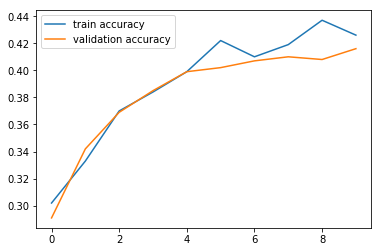

In [102]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [103]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 100


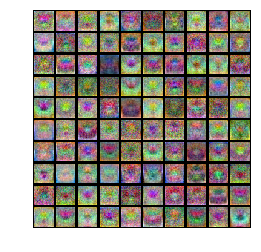

In [104]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Get test accuracy greater than 48%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 48%. If your accuracy is lower, for each 1% lower than 48%, you will lose 1 point. On the other hand, you will get one extra point for every 1% higher than 52%.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc. For example, if you change SGD into SGD with momentum, then you should get about 2% increase in accuracy.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```
    
<span style="color:red"><strong>TODO</strong></span>: See below

In [116]:
# TODO
#  from ecbm4040.classifiers.twolayernet import TwoLayerNet

# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)




from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=750, num_classes=10, reg=0.35, weight_scale=1e-3)

num_epoch = 15
batch_size = 250
lr = 1e-3
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)







number of batches for training: 196


/home/ob2285/Desktop/currentClasses/NNetsDL_F17/assignment1/assignment1/ecbm4040/layer_funcs.py:150: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(sm[np.arange(N), y]))/N


2500/49000 loss: 13.44810790660087
5000/49000 loss: 3.963670088796662
7500/49000 loss: 8.722028004598723
10000/49000 loss: 11.379414915708692
12500/49000 loss: 6.4818492353044705
15000/49000 loss: 3.3466073797282387
17500/49000 loss: 3.3709241714282743
20000/49000 loss: 4.116312927956307
22500/49000 loss: 2.6819429901965615
25000/49000 loss: 2.367382891938462
27500/49000 loss: 2.0472562827283847
30000/49000 loss: 2.0667294827163145
32500/49000 loss: 1.980528636576324
35000/49000 loss: 2.0089428855378686
37500/49000 loss: 1.9553902342542382
40000/49000 loss: 1.9089429801123337
42500/49000 loss: 1.8939754636872177
45000/49000 loss: 1.8685198258395037
47500/49000 loss: 1.8972750345785303
(1000, 10)
(1000, 10)
epoch 1: valid acc = 0.349, new learning rate = 0.00095
2500/49000 loss: 1.772337367595175
5000/49000 loss: 1.8591816702205923
7500/49000 loss: 1.8433327167348412
10000/49000 loss: 1.8446851511866145
12500/49000 loss: 1.8338174284929438
15000/49000 loss: 1.8659330834191332
17500/4900

27500/49000 loss: 1.7841288985310284
30000/49000 loss: 1.641832909262324
32500/49000 loss: 1.7150831996994882
35000/49000 loss: 1.6884047379778964
37500/49000 loss: 1.7487790246233046
40000/49000 loss: 1.6482170083920356
42500/49000 loss: 1.6653153454905243
45000/49000 loss: 1.718753823456006
47500/49000 loss: 1.6913412522704394
(1000, 10)
(1000, 10)
epoch 11: valid acc = 0.424, new learning rate = 0.0005688000922764595
2500/49000 loss: 1.5973657452775012
5000/49000 loss: 1.7096106635626267
7500/49000 loss: 1.7437416066421707
10000/49000 loss: 1.6831185920193177
12500/49000 loss: 1.6356316486718194
15000/49000 loss: 1.7437749861676912
17500/49000 loss: 1.6381311392772084
20000/49000 loss: 1.633236582929823
22500/49000 loss: 1.8096269171183081
25000/49000 loss: 1.7359140583036548
27500/49000 loss: 1.7818439431690674
30000/49000 loss: 1.6370612735450984
32500/49000 loss: 1.7097483365495394
35000/49000 loss: 1.6850279287903327
37500/49000 loss: 1.746039522729708
40000/49000 loss: 1.644329

0.42099999999999999

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

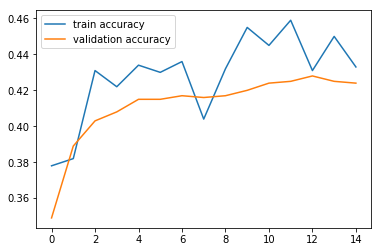

In [117]:
# TODO: plot training and validation accuracy
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 750


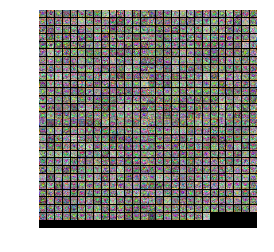

In [118]:
# TODO: Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [119]:
# Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [120]:
# Load your model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./ecbm4040/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network. Complete the "<span style="color:red"><strong>TODO</strong></span>" part.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

In [133]:
from ecbm4040.classifiers.mlp import MLP

# TODO: Use a sequence of layers to create a multiple layer neural network
# input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 50, 50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.3024935359487984
10000/49000 loss: 2.3024591963778285
15000/49000 loss: 2.3023014714526777
20000/49000 loss: 2.302287867059934
25000/49000 loss: 2.3023569762325193
30000/49000 loss: 2.302180899445717
35000/49000 loss: 2.3020034538857552
40000/49000 loss: 2.3020008420042117
45000/49000 loss: 2.3019672412489327
epoch 1: valid acc = 0.126, new learning rate = 0.0095
5000/49000 loss: 2.3009263441757755
10000/49000 loss: 2.301020512867766
15000/49000 loss: 2.2994041387015525
20000/49000 loss: 2.2991705220834735
25000/49000 loss: 2.299270416595747
30000/49000 loss: 2.2966243702289124
35000/49000 loss: 2.292087258483244
40000/49000 loss: 2.2898753428320693
45000/49000 loss: 2.287691732836597
epoch 2: valid acc = 0.125, new learning rate = 0.009025
5000/49000 loss: 2.257275690663297
10000/49000 loss: 2.275979077479142
15000/49000 loss: 2.2404476299616594
20000/49000 loss: 2.2606235181600147
25000/49000 loss: 2.2609370754703044
30000/49000 l

0.1701

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net. You need to implement a multi-layer with 3 or 4 layers.

In [8]:
# Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.20100000500679016
epoch 2: valid acc = 0.24500000476837158
epoch 3: valid acc = 0.2750000059604645
epoch 4: valid acc = 0.2939999997615814
epoch 5: valid acc = 0.3109999895095825
epoch 6: valid acc = 0.3370000123977661
epoch 7: valid acc = 0.3610000014305115
epoch 8: valid acc = 0.38100001215934753
epoch 9: valid acc = 0.3799999952316284
epoch 10: valid acc = 0.3930000066757202
test acc = 0.3930000066757202


<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., weights and bias. Besides, consider to use a loop to create your MLP network.

In [7]:
# For example
#weights = {
#    'w1': tf.Variable(),
#    'w2': tf.Variable()),
#    'w3': tf.Variable()),
#    'w4': tf.Variable()),
#    ...
#}
hidden_dim_1 = 250
hidden_dim_2 = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf_mine = tf.Variable(1e-2*np.random.rand(3072, hidden_dim_1).astype('float32'))
b1_tf_mine = tf.Variable(np.zeros((hidden_dim_1,)).astype('float32'))

W2_tf_mine = tf.Variable(1e-2*np.random.rand(hidden_dim_1, hidden_dim_2).astype('float32'))
b2_tf_mine = tf.Variable(np.zeros((hidden_dim_2,)).astype('float32'))

W3_tf_mine = tf.Variable(1e-2*np.random.rand(hidden_dim_2, 10).astype('float32'))
b3_tf_mine = tf.Variable(np.zeros((10,)).astype('float32'))


h1_tf_mine = tf.nn.relu(tf.matmul(x_tf, W1_tf_mine) + b1_tf_mine)
h2_tf_mine = tf.nn.relu(tf.matmul(h1_tf_mine, W2_tf_mine) + b2_tf_mine)
h3_tf_mine = tf.matmul(h2_tf_mine, W3_tf_mine) + b3_tf_mine


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h3_tf_mine, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf_mine)  + tf.nn.l2_loss(W3_tf_mine) + tf.nn.l2_loss(W2_tf_mine)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h3_tf_mine,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.12800000607967377
epoch 2: valid acc = 0.14499999582767487
epoch 3: valid acc = 0.14499999582767487
epoch 4: valid acc = 0.14499999582767487
epoch 5: valid acc = 0.14499999582767487
epoch 6: valid acc = 0.16899999976158142
epoch 7: valid acc = 0.164000004529953
epoch 8: valid acc = 0.1589999943971634
epoch 9: valid acc = 0.15800000727176666
epoch 10: valid acc = 0.1589999943971634
test acc = 0.1589999943971634
